# Tutorial: Linear algebra on n-dimensional arrays

## Prerequisites

Before reading this tutorial, you should know a bit of Python. If you would like to refresh your memory, take a look at the [Python tutorial](https://docs.python.org/3/tutorial/).

If you want to be able to run the examples in this tutorial, you should also have [matplotlib](https://matplotlib.org/) and [SciPy](https://scipy.org) installed on your computer.

## Learner profile

This tutorial is for people who have a basic understanding of linear algebra and arrays in NumPy and want to understand how n-dimensional ($n>=2$) arrays are represented and can be manipulated. In particular, if you don't know how to apply common functions to n-dimensional arrays (without using for-loops), or if you want to understand axis and shape properties for n-dimensional arrays, this tutorial might be of help.

## Learning Objectives

After this tutorial, you should be able to:

- Understand the difference between one-, two- and n-dimensional arrays in NumPy;
- Understand how to apply some linear algebra operations to n-dimensional arrays without using for-loops;
- Understand axis and shape properties for n-dimensional arrays.

## Content

In this tutorial, we will use a [matrix decomposition](https://en.wikipedia.org/wiki/Matrix_decomposition) from linear algebra, the Singular Value Decomposition, to generate a compressed approximation of an image. We'll use the `face` image from the [scipy.misc](https://docs.scipy.org/doc/scipy/reference/misc.html#module-scipy.misc) module:

In [1]:
from scipy import misc
img = misc.face()

**Note**: If you prefer, you can use your own image as you work through this tutorial. In order to transform your image into a NumPy array that can be manipulated, you can use the `imread` function from the [matplotlib.pyplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot) submodule. Alternatively, you can use the [imageio.imread](https://imageio.readthedocs.io/en/stable/userapi.html#imageio.imread) function from the `imageio` library. Be aware that if you use your own image, you'll likely need to adapt the steps below. For more information on how images are treated when converted to NumPy arrays, see [A crash course on NumPy for images](https://scikit-image.org/docs/stable/user_guide/numpy_images.html) from the `scikit-image` documentation.

Now, `img` is a NumPy array, as we can see when using the `type` function:

In [2]:
type(img)

numpy.ndarray

We can see the image using the [matplotlib.pyplot.imshow](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib.pyplot.imshow) function & the special iPython command, `%matplotlib inline` to display plots inline:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

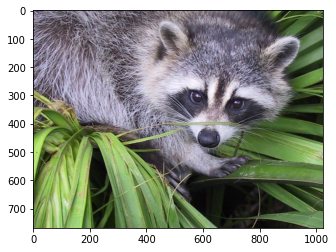

In [4]:
plt.imshow(img)
plt.show()

### Shape, axis and array properties

Note that, in linear algebra, the dimension of a vector refers to the number of entries in an array. In NumPy, it instead defines the number of axes. For example, a 1D array is a vector such as `[1, 2, 3]`, a 2D array is a matrix, and so forth.

First, let's check for the shape of the data in our array. Since this image is two-dimensional (the pixels in the image form a rectangle), we might expect a two-dimensional array to represent it (a matrix). However, using the `shape` property of this NumPy array gives us a different result:

In [5]:
img.shape

(768, 1024, 3)

The output is a [tuple](https://docs.python.org/dev/tutorial/datastructures.html#tut-tuples) with three elements, which means that this is a three-dimensional array. In fact, since this is a color image, and we have used the `imread` function to read it, the data is organized in three 2D arrays, representing color channels (in this case, red, green and blue - RGB). You can see this by looking at the shape above: it indicates that we have an array of 3 matrices, each having shape 768x1024.

Furthermore, using the `ndim` property of this array, we can see that

In [6]:
img.ndim

3

NumPy refers to each dimension as an *axis*. Because of how `imread` works, the *first index in the 3rd axis* is the red pixel data for our image. We can access this by using the syntax

In [7]:
img[:, :, 0]

array([[121, 138, 153, ..., 119, 131, 139],
       [ 89, 110, 130, ..., 118, 134, 146],
       [ 73,  94, 115, ..., 117, 133, 144],
       ...,
       [ 87,  94, 107, ..., 120, 119, 119],
       [ 85,  95, 112, ..., 121, 120, 120],
       [ 85,  97, 111, ..., 120, 119, 118]], dtype=uint8)

From the output above, we can see that every value in `img[:, :, 0]` is an integer value between 0 and 255, representing the level of red in each corresponding image pixel (keep in mind that this might be different if you
use your own image instead of [scipy.misc.face](https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.face.html#scipy.misc.face)).

As expected, this is a 768x1024 matrix:

In [8]:
img[:, :, 0].shape

(768, 1024)

Since we are going to perform linear algebra operations on this data, it might be more interesting to have real numbers between 0 and 1 in each entry of the matrices to represent the RGB values. We can do that by setting

In [9]:
img_array = img / 255

This operation, dividing an array by a scalar, works because of NumPy's [broadcasting rules](https://numpy.org/devdocs/user/theory.broadcasting.html#array-broadcasting-in-numpy). (Note that in real-world applications, it would be better to use, for example, the [img_as_float](https://scikit-image.org/docs/stable/api/skimage.html#skimage.img_as_float) utility function from `scikit-image`).

You can check that the above works by doing some tests; for example, inquiring
about maximum and minimum values for this array:

In [10]:
img_array.max(), img_array.min()

(1.0, 0.0)

or checking the type of data in the array:

In [11]:
img_array.dtype

dtype('float64')

Note that we can assign each color channel to a separate matrix using the slice syntax:

In [12]:
red_array = img_array[:, :, 0]
green_array = img_array[:, :, 1]
blue_array = img_array[:, :, 2]

### Operations on an axis

It is possible to use methods from linear algebra to approximate an existing set of data. Here, we will use the [SVD (Singular Value Decomposition)](https://en.wikipedia.org/wiki/Singular_value_decomposition) to try to rebuild an image that uses less singular value information than the original one, while still retaining some of its features.

**Note**: We will use NumPy's linear algebra module, [numpy.linalg](https://numpy.org/devdocs/reference/routines.linalg.html#module-numpy.linalg), to perform the operations in this tutorial. Most of the linear algebra functions in this module can also be found in [scipy.linalg](https://docs.scipy.org/doc/scipy/reference/linalg.html#module-scipy.linalg), and users are encouraged to use the [scipy](https://docs.scipy.org/doc/scipy/reference/index.html#module-scipy) module for real-world applications. However, some functions in the [scipy.linalg](https://docs.scipy.org/doc/scipy/reference/linalg.html#module-scipy.linalg) module, such as the SVD function, only support 2D arrays. For more information on this, check the [scipy.linalg Reference](https://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html).

To proceed, import the linear algebra submodule from NumPy:

In [13]:
from numpy import linalg

In order to extract information from a given matrix, we can use the SVD to obtain 3 arrays which can be multiplied to obtain the original matrix. From the theory of linear algebra, given a matrix $A$, the following product can be computed:

$$U \Sigma V^T = A$$

where $U$ and $V^T$ are square and $\Sigma$ is the same size as $A$. $\Sigma$ is a diagonal matrix and contains the [singular values](https://en.wikipedia.org/wiki/Singular_value) of $A$, organized from largest to smallest. These values are always non-negative and can be used as an indicator of the "importance" of some features represented by the matrix $A$.

Let's see how this works in practice with just one matrix first. Note that according to [colorimetry](https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-reserving)_conversion_to_grayscale),
it is possible to obtain a fairly reasonable grayscale version of our color image if we apply the formula

$$Y = 0.2126 R + 0.7152 G + 0.0722 B$$

where $Y$ is the array representing the grayscale image, and $R$, $G$ and $B$ are the red, green and blue channel arrays we had originally. Notice we can use the `@` operator (the matrix multiplication operator for NumPy arrays, see [numpy.matmul](https://numpy.org/devdocs/reference/generated/numpy.matmul.html#numpy.matmul)) for this:

In [14]:
img_gray = img_array @ [0.2126, 0.7152, 0.0722]

Now, `img_gray` has shape

In [15]:
img_gray.shape

(768, 1024)

To see if this makes sense in our image, we should use a colormap from `matplotlib` corresponding to the color we wish to see in out image (otherwise, `matplotlib` will default to a colormap that does not correspond to the real data).

In our case, we are approximating the grayscale portion of the image, so we will use the colormap `gray`:

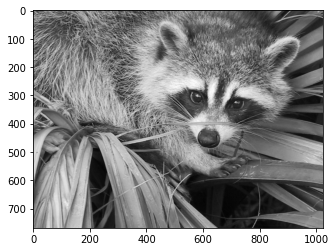

In [16]:
plt.imshow(img_gray, cmap="gray")
plt.show()

Now, applying the [linalg.svd](https://numpy.org/devdocs/reference/generated/numpy.linalg.svd.html#numpy.linalg.svd) function to this matrix, we obtain the following decomposition:

In [17]:
U, s, Vt = linalg.svd(img_gray)

**Note** If you are using your own image, this command might take a while to run, depending on the size of your image and your hardware. Don't worry, this is normal! The SVD can be a pretty intensive computation.

Let's check that this is what we expected:

In [18]:
U.shape, s.shape, Vt.shape

((768, 768), (768,), (1024, 1024))

Note that `s` has a particular shape: it has only one dimension. This means that some linear algebra functions that expect 2d arrays might not work. For example, from the theory, one might expect `s` and `Vt` to be
compatible for multiplication. However, this is not true as `s` does not have a second axis. Executing

```python
s @ Vt
```

results in a `ValueError`. This happens because having a one-dimensional array for `s`, in this case, is much more economic in practice than building a diagonal matrix with the same data. To reconstruct the original matrix, we can rebuild the diagonal matrix $\Sigma$ with the elements of `s` in its diagonal and with the appropriate dimensions for multiplying: in our case, $\Sigma$ should be 768x1024 since `U` is 768x768 and `Vt` is 1024x1024.

In [19]:
import numpy as np
Sigma = np.zeros((U.shape[1], Vt.shape[0]))
np.fill_diagonal(Sigma, s)

Now, we want to check if the reconstructed `U @ Sigma @ Vt` is close to the original `img_gray` matrix.

## Approximation

The [linalg](https://numpy.org/devdocs/reference/routines.linalg.html#module-numpy.linalg) module includes a `norm` function, which computes the norm of a vector or matrix represented in a NumPy array. For example, from the SVD explanation above, we would expect the norm of the difference between `img_gray` and the reconstructed SVD product to be small. As expected, you should see something like

In [20]:
linalg.norm(img_gray - U @ Sigma @ Vt)

1.4370019510674343e-12

(The actual result of this operation might be different depending on your architecture and linear algebra setup. Regardless, you should see a small number.)

We could also have used the [numpy.allclose](https://numpy.org/devdocs/reference/generated/numpy.allclose.html#numpy.allclose) function to make sure the reconstructed product is, in fact, *close* to our original matrix (the difference between the two arrays is small):

In [21]:
np.allclose(img_gray, U @ Sigma @ Vt)

True

To see if an approximation is reasonable, we can check the values in `s`:

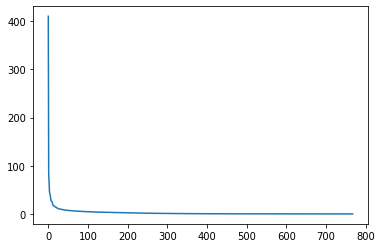

In [22]:
plt.plot(s)
plt.show()

In the graph, we can see that although we have 768 singular values in `s`, most of those (after the 150th entry or so) are pretty small. So it might make sense to use only the information related to the first (say, 50) *singular values* to build a more economical approximation to our image.

The idea is to consider all but the first `k` singular values in `Sigma` (which are the same as in `s`) as zeros, keeping `U` and `Vt` intact, and computing the product of these matrices as the approximation.

For example, if we choose

In [23]:
k = 10

we can build the approximation by doing

In [24]:
approx = U @ Sigma[:, :k] @ Vt[:k, :]

Note that we had to use only the first `k` rows of `Vt`, since all other rows would be multiplied by the zeros corresponding to the singular values we eliminated from this approximation.

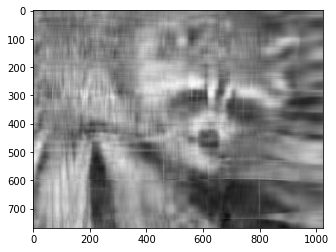

In [25]:
plt.imshow(approx, cmap="gray")
plt.show()

Now, you can go ahead and repeat this experiment with other values of `k`, and each of your experiments should give you a slightly better (or worse) image depending on the value you choose.

### Applying to all colors

Now we want to do the same kind of operation, but to all three colors. Our first instinct might be to repeat the same operation we did above to each color matrix individually. However, NumPy's *broadcasting* takes care of this
for us.

If our array has more than two dimensions, then the SVD can be applied to all axes at once. However, the linear algebra functions in NumPy expect to see an array of the form `(n, M, N)`, where the first axis `n` represents the number of `MxN` matrices in the stack.

In our case,

In [26]:
img_array.shape

(768, 1024, 3)

so we need to permutate the axis on this array to get a shape like `(3, 768, 1024)`. Fortunately, the [numpy.transpose](https://numpy.org/devdocs/reference/generated/numpy.transpose.html#numpy.transpose) function can do that for us:
```
np.transpose(x, axes=(i, j, k))
```
indicates that the axis will be reordered such that the final shape of the transposed array will be reordered according to the indices `(i, j, k)`.

Let's see how this goes for our array:

In [27]:
img_array_transposed = np.transpose(img_array, (2, 0, 1))
img_array_transposed.shape

(3, 768, 1024)

Now we are ready to apply the SVD:

In [28]:
U, s, Vt = linalg.svd(img_array_transposed)

Finally, to obtain the full approximated image, we need to reassemble these matrices into the approximation. Now, note that

In [29]:
U.shape, s.shape, Vt.shape

((3, 768, 768), (3, 768), (3, 1024, 1024))

To build the final approximation matrix, we must understand how multiplication across different axes works.

### Products with n-dimensional arrays

If you have worked before with only one- or two-dimensional arrays in NumPy, you might use [numpy.dot](https://numpy.org/devdocs/reference/generated/numpy.dot.html#numpy.dot) and [numpy.matmul](https://numpy.org/devdocs/reference/generated/numpy.matmul.html#numpy.matmul) (or the `@` operator) interchangeably. However, for n-dimensional arrays, they work in very different ways. For more details, check the documentation on [numpy.matmul](https://numpy.org/devdocs/reference/generated/numpy.matmul.html#numpy.matmul).

Now, to build our approximation, we first need to make sure that our singular values are ready for multiplication, so we build our `Sigma` matrix similarly to what we did before. The `Sigma` array must have dimensions `(3, 768, 1024)`. In order to add the singular values to the diagonal of `Sigma`, we will use the [fill_diagonal](https://numpy.org/devdocs/reference/generated/numpy.fill_diagonal.html) function from NumPy, using each of the 3 rows in `s` as the diagonal for each of the 3 matrices in `Sigma`:

In [30]:
Sigma = np.zeros((3, 768, 1024))
for j in range(3):
    np.fill_diagonal(Sigma[j, :, :], s[j, :])

Now, if we wish to rebuild the full SVD (with no approximation), we can do

In [31]:
reconstructed = U @ Sigma @ Vt

Note that

In [32]:
reconstructed.shape

(3, 768, 1024)

The reconstructed image should be indistinguishable from the original one, except for differences due to floating point errors from the reconstruction. Recall that our original image consisted of floating point values in the range `[0., 1.]`. The accumulation of floating point error from the reconstruction can result in values slightly outside this original range:

In [33]:
reconstructed.min(), reconstructed.max()

(-5.533984728800512e-15, 1.0000000000000056)

Since `imshow` expects values in the range, we can use `clip` to excise the floating point error:

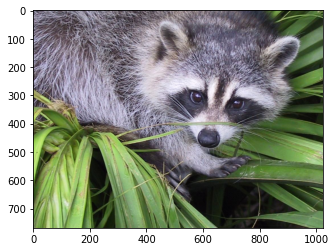

In [34]:
reconstructed = np.clip(reconstructed, 0, 1)
plt.imshow(np.transpose(reconstructed, (1, 2, 0)))
plt.show()

In fact, `imshow` peforms this clipping under-the-hood, so if you skip the first line in the previous code cell, you might see a warning message saying `"Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)."`

Now, to do the approximation, we must choose only the first `k` singular values for each color channel. This can be done using the following syntax:

In [35]:
approx_img = U @ Sigma[..., :k] @ Vt[..., :k, :]

You can see that we have selected only the first `k` components of the last axis for `Sigma` (this means that we have used only the first `k` columns of each of the three matrices in the stack), and that we have selected only the first `k` components in the second-to-last axis of `Vt` (this means we have selected only the first `k` rows from every matrix in the stack `Vt` and all columns). If you are unfamiliar with the ellipsis syntax, it is a
placeholder for other axes. For more details, see the documentation on [Indexing](https://numpy.org/devdocs/user/basics.indexing.html#basics-indexing).

Now,

In [36]:
approx_img.shape

(3, 768, 1024)

which is not the right shape for showing the image. Finally, reordering the axes back to our original shape of `(768, 1024, 3)`, we can see our approximation:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


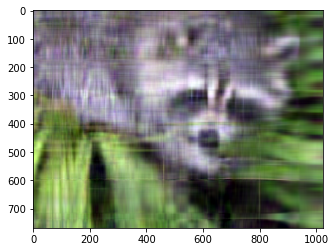

In [37]:
plt.imshow(np.transpose(approx_img, (1, 2, 0)))
plt.show()

Even though the image is not as sharp, using a small number of `k` singular values (compared to the original set of 768 values), we can recover many of the distinguishing features from this image.

### Final words

Of course, this is not the best method to *approximate* an image. However, there is, in fact, a result in linear algebra that says that the approximation we built above is the best we can get to the original matrix in
terms of the norm of the difference. For more information, see *G. H. Golub and C. F. Van Loan, Matrix Computations, Baltimore, MD, Johns Hopkins University Press, 1985*.

## Further reading

-  [Python tutorial](https://docs.python.org/dev/tutorial/index.html)
-  [NumPy Reference](https://numpy.org/devdocs/reference/index.html#reference)
-  [SciPy Tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/index.html)
-  [SciPy Lecture Notes](https://scipy-lectures.org)
-  [A matlab, R, IDL, NumPy/SciPy dictionary](http://mathesaurus.sf.net/)